### Imports

In [1]:
# Importing necessary libraries and modules

# General
import numpy as np  # Importing numpy for numerical operations

# Data Management
import pandas as pd  # Importing pandas for data manipulation and analysis
import polars as pl
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting data into training and testing sets

# Machine Learning
from xgboost import XGBClassifier  # Importing XGBClassifier for extreme gradient boosting classification
from sklearn.model_selection import RandomizedSearchCV, cross_val_score  # Importing RandomizedSearchCV for hyperparameter tuning, cross_val_score for cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold  # Importing RepeatedStratifiedKFold for repeated stratified k-fold cross-validation

# Binary Classification Specific Metrics
# Alternative method for plotting the ROC curve
from sklearn.metrics import roc_curve, auc  # Importing roc_curve and auc for ROC curve and AUC calculation

# General Metrics
from sklearn.metrics import accuracy_score, classification_report  # Importing accuracy_score and classification_report for model evaluation
from sklearn.metrics import precision_score, confusion_matrix  # Importing precision_score and confusion_matrix for precision and confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay  # Importing ConfusionMatrixDisplay for displaying confusion matrix

# Reporting
import matplotlib.pyplot as plt  # Importing pyplot from matplotlib for plotting
from matplotlib.pylab import rcParams  # Importing rcParams from matplotlib for setting plot parameters
from xgboost import plot_tree  # Importing plot_tree from xgboost for visualizing decision trees

# Function to plot ROC curve
def plot_roc(model, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

### Data Management

In [2]:
# Data Extraction

df = pl.read_csv("data/BTC-USD.csv") # Read the CSV file into a polars df


df = df.with_columns(pl.col("date").cast(pl.Datetime)) # now will have datetime dtype

# Sort the DataFrame by the 'date' column in ascending order, argument ensures oldest dates come first.
df = df.sort("date", descending=False)

### Add Target

In [3]:
# Specify Target
df = df.with_columns([
    (pl.when(pl.col('range').shift(-1) > pl.col('average range'))  # Compare the 'range' shift less one column with 'average range'
        .then(1)  # If the condition is true, set 'TARGET' to 1
        .otherwise(0))  # If the condition is false, set 'TARGET' to 0
        .alias('TARGET')  # Name the new column 'TARGET'
])
# This allows you to create a target variable based on whether the 'range' of the next day is greater than or less than
# the 'average range' of the current day.

In [4]:
# Check for NaNs
nan_location = df.select(pl.all().is_null()).to_numpy().nonzero()
# pl.all().is_null(): Creates a boolean mask for NaNs.
# .to_numpy(): Converts the mask to a NumPy array.
# .nonzero(): Retrieves the indices of the True values in the boolean mask, indicating the positions of NaNs.

nan_location

(array([], dtype=int64), array([], dtype=int64))

In [5]:
# Fill NA if needed
df = df.with_columns(pl.col("TARGET").fill_nan(0))
df.tail()

date,DOW,open,high,low,close,adj_close,volume,returns,range,Bench_C_Rets,RSI,RSI_Ret,MA_12,MA_21,rolling returns,average range,returns_1,range_1,RSI_Ret_1,returns_2,range_2,RSI_Ret_2,returns_3,range_3,RSI_Ret_3,returns_4,range_4,RSI_Ret_4,returns_5,range_5,RSI_Ret_5,returns_6,range_6,RSI_Ret_6,returns_7,range_7,RSI_Ret_7,TARGET
datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2024-07-14 00:00:00,6,0.022734,0.025799,0.024721,60787.792969,60787.792969,0.301132,0.026267,0.03553,0.163694,44.348685,0.982906,57973.966146,59473.93006,-0.075268,0.034931,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0.022998,0.034134,0.981631,0.015327,0.070144,1.25864,-0.042097,0.046203,0.931954,1
2024-07-15 00:00:00,0,0.02685,0.057731,0.024984,64870.152344,64870.152344,0.714162,0.067158,0.068614,0.162156,54.890198,1.237696,58365.318685,59692.631882,-0.010836,0.03695,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0.022998,0.034134,0.981631,0.015327,0.070144,1.25864,1
2024-07-16 00:00:00,1,0.065262,0.007464,0.029372,65097.148438,65097.148438,0.092476,0.003499,0.045871,0.162061,57.655443,1.050378,59041.939128,59849.417969,-0.014105,0.038036,0.067158,0.068614,1.237696,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0.022998,0.034134,0.981631,0
2024-07-17 00:00:00,2,0.004745,0.0109,0.022534,64118.792969,64118.792969,-0.218473,-0.015029,0.033972,0.161807,60.293388,1.045754,59663.307292,60006.918713,-0.026902,0.038097,0.003499,0.045871,1.050378,0.067158,0.068614,1.237696,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0
2024-07-18 00:00:00,3,-0.015165,-0.014562,-0.010172,63974.066406,63974.066406,-0.162514,-0.002257,0.029385,0.161775,71.713449,1.189408,60135.851237,60119.740885,-0.008863,0.037781,-0.015029,0.033972,1.045754,0.003499,0.045871,1.050378,0.067158,0.068614,1.237696,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,0


### Train Test Split

In [6]:
# Feature Selection. We are using the features identified as the top
df_tts = df.clone()

# Select the specified columns
df_tts = df_tts.select([
    "DOW", 
    "volume", 
    "returns", 
    "range", 
    "RSI", 
    "average range", 
    "range_1",
    "range_2", 
    "RSI_Ret_2", 
    "range_4", 
    "range_6",
    "TARGET"
])

# Display the first few rows of the new DataFrame
df_tts.tail(5)


DOW,volume,returns,range,RSI,average range,range_1,range_2,RSI_Ret_2,range_4,range_6,TARGET
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
6,0.301132,0.026267,0.03553,44.348685,0.034931,0.034442,0.034324,1.136591,0.038144,0.070144,1
0,0.714162,0.067158,0.068614,54.890198,0.03695,0.03553,0.034442,1.060974,0.038148,0.034134,1
1,0.092476,0.003499,0.045871,57.655443,0.038036,0.068614,0.03553,0.982906,0.034324,0.038144,0
2,-0.218473,-0.015029,0.033972,60.293388,0.038097,0.045871,0.068614,1.237696,0.034442,0.038148,0
3,-0.162514,-0.002257,0.029385,71.713449,0.037781,0.033972,0.045871,1.050378,0.03553,0.034324,0


In [7]:
# Split into Learning (X) and Target (y) Data

# Last column is the target column
target_column = "TARGET"

# Select feature columns and target column
feature_columns = [
    "DOW", 
    "volume", 
    "returns", 
    "range", 
    "RSI", 
    "average range", 
    "range_1",
    "range_2", 
    "RSI_Ret_2", 
    "range_4", 
    "range_6"
]

# Create X (features) and y (target), needs to be in numpy since sklearn uses numpy or pandas
X = df_tts.select(feature_columns).to_numpy()
y = df_tts.select([target_column]).to_numpy().ravel()  # Ensure y is a 1D array


# Display the first 3 rows of the numpy arrays X and y
print("First 3 rows of X:")
print(X[:3])

print(" ")

# Display the first 3 elements of the numpy array y_train
print("First 3 elements of y:")
print(y[:3])

First 3 rows of X:
[[ 1.00000000e+00  1.10389478e+00  5.43480805e-02  5.54422058e-02
   6.72213683e+01  5.79102306e-02  3.88697735e-03  4.64562778e-03
   9.84746588e-01  8.05486304e-03  1.29698003e-02]
 [ 2.00000000e+00 -8.79318516e-02  1.91878991e-02  1.89257384e-02
   7.86593444e+01  5.73809963e-02  5.54422058e-02  3.88697735e-03
   9.83884377e-01  4.45747739e-03  1.89553700e-02]
 [ 3.00000000e+00 -2.85724335e-02  2.30297751e-02  3.08160739e-02
   7.98249504e+01  5.76747094e-02  1.89257384e-02  5.54422058e-02
   9.41683925e-01  4.64562778e-03  8.05486304e-03]]
 
First 3 elements of y:
[0 0 0]


In [8]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the train and test sets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2180, 11)
Shape of y_train:  (2180,)
Shape of X_test:  (546, 11)
Shape of y_test:  (546,)


In [9]:
# Perform Train Test Split (Timeseries based method)
# Define the training size rate
train_size_rate = 0.7

# Calculate the number of training samples
train_size = int(len(X) * train_size_rate)

# Calculate the number of testing samples
test_size = len(X) - train_size

# Split the features (X) and target (y) into training and testing sets
# The first 'train_size' rows for training and the remaining rows for testing
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Validate that the sizes match
size_check = (len(y_test) + len(y_train)) == len(y)

# Print shapes of the training and testing sets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)



Shape of X_train:  (1908, 11)
Shape of y_train:  (1908,)
Shape of X_test:  (818, 11)
Shape of y_test:  (818,)
Size Matches:  True


### Build Model

In [10]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

# Purpose:
# is_binary: 
#   - True: We're building a binary classification model
#   - False: We're building a multi-class classification model
# This flag determines the objective function and evaluation metrics we use.

In [11]:
# Determine Objective and Evaluation Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [12]:
# Refine Evaluation Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"  # Area Under the Precision-Recall Curve
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"  # Area Under the ROC Curve
    scoring = "f1"  # F1 Score balances precision and recall
else:
    scoring = "accuracy"


In [13]:
(eval_metric, eval_metric_list)

('aucpr', ['error', 'logloss', 'logloss'])

In [14]:
# Copied from sec9.69 Feature Selection. There we algorithmically came up with the Hyperparams
# Hyperparams: ne: 100, lr: 0.1 md: 3 gm: 6
ne = 50 # number of estimators
lr = 0.1 # learning rate
md = 3 # max depth
gm = 6 # gamma

In [15]:
# XGBOOST Classifier
from xgboost import XGBClassifier

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

#This is proper way to do it I am loading config used by the instructor
classifier = XGBClassifier(
    objective=objective,  
    booster="gbtree",  
    eval_metric=eval_metric_list,  
    n_estimators=ne,  
    learning_rate=lr,  
    max_depth=md,  
    gamma=gm,  
    subsample=0.8,  
    colsample_bytree=1,  # All features considered for each tree
    random_state=1,  # Ensures reproducibility
    use_label_encoder=False  # Prevents auto-encoding of string labels (avoids warnings)
)

# # Instructor config
# classifier = XGBClassifier(
#     base_score=0.5, booster='gbtree', colsample_bylevel=1,
#     colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
#     eval_metric='aucpr', gamma=6, gpu_id=-1, importance_type=None,
#     interaction_constraints='', learning_rate=0.01, max_delta_step=0,
#     max_depth=3, min_child_weight=1, missing=float('nan'),
#     monotone_constraints='()', n_estimators=80, n_jobs=8,
#     num_parallel_tree=1, predictor='auto', random_state=1,
#     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
#     tree_method='exact', use_label_encoder=False,
#     validate_parameters=1, verbosity=None
# )
    

In [16]:
# Prepare evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit the classifier
classifier.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

print(classifier)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


### Make Predictions

In [17]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Predictions Training Data: \n", train_yhat[:10])
print(" ")
print("Predictions Probabilities Training Data: \n", train_yhat_proba[:3])


Predictions Training Data: 
 [0 0 0 0 0 0 0 1 1 1]
 
Predictions Probabilities Training Data: 
 [[0.7822864  0.21771356]
 [0.72073925 0.27926075]
 [0.80970967 0.19029033]]


In [18]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Predictions Test Data: \n", test_yhat[:10])
print(" ")
print("Predictions Probabilities Test Data: \n", test_yhat_proba[:3])


Predictions Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
 
Predictions Probabilities Test Data: 
 [[0.7938826  0.20611742]
 [0.6353705  0.36462954]
 [0.6683388  0.3316612 ]]


## Adjusting Trade Size Based on Prediction Probabilities

The prediction probabilities from our XGBoost model can be leveraged to dynamically adjust trade sizes, potentially improving our strategy's Sharpe ratio. Here's how:

1. **Probability Threshold**: Set a minimum probability threshold (e.g., 0.6) for taking trades.

2. **Scaling Factor**: Use the probability as a scaling factor for trade size.

3. **Base Position Size**: Determine a base position size for your strategy.

4. **Adjusted Position Size**: Calculate the adjusted position size as:
   adjusted_size = base_size * (probability / threshold)

5. **Capping**: Implement a maximum position size to manage risk.

Example implementation:
```python
def adjust_trade_size(probability, base_size, threshold=0.6, max_size=2.0):
 if probability < threshold:
     return 0  # Don't trade
 
 scaling_factor = min(probability / threshold, max_size)
 return base_size * scaling_factor

In [19]:
# Set K-fold Cross Validation Levels
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=1,
    random_state=1
)

In [20]:
# Training Results
train_results = cross_val_score(
    classifier, 
    X_train,
    y_train,
    scoring=scoring, # list of metrics to evaluate the model's performance from cell 12
    cv=cv, #cross-validation splitting strategy
    n_jobs=1 # computation will use 1 CPU core. You could increase this for parallel processing if your system allows.
)

### Evaluation Metrics - Loss and Overfitting

In [21]:
# Retrieve performance metrics
results = classifier.evals_result()

# Print available metrics
print("Available metrics:", list(results['validation_0'].keys()))

Available metrics: ['error', 'logloss']


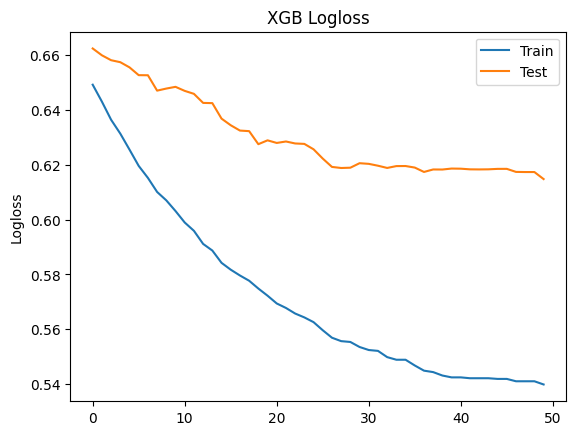

In [22]:
# Retrieve performance metrics
results = classifier.evals_result()

# Get the number of epochs
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Logloss')
plt.title('XGB Logloss')
plt.show()

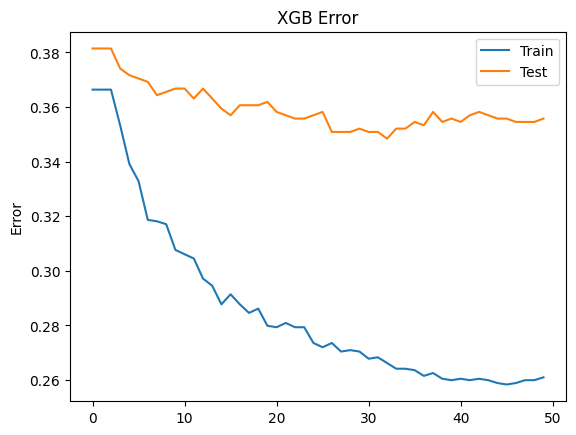

In [23]:
# Plot Error Rate
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGB Error')
plt.show()

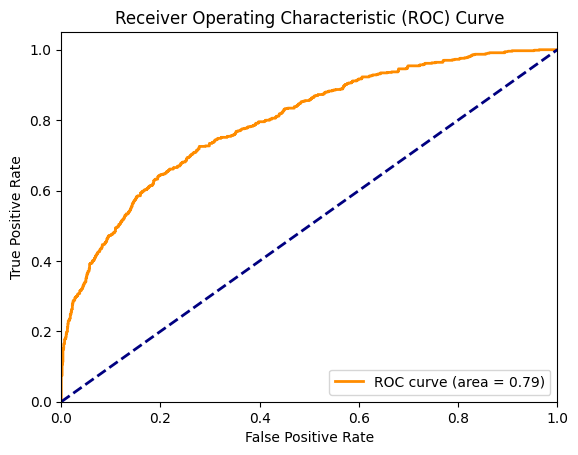

In [24]:
# Plot Training ROC Curve
plot_roc(classifier, X_train, y_train)

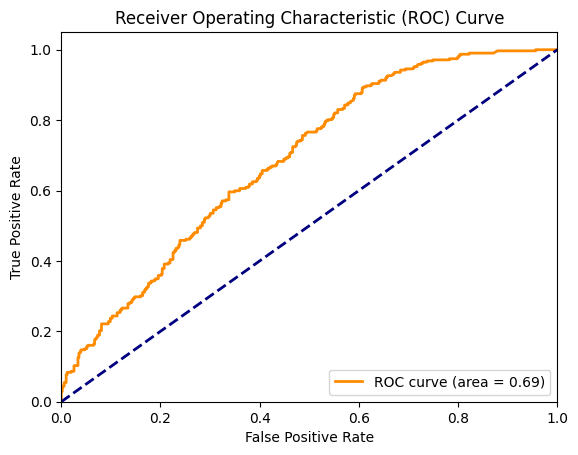

In [26]:
# Plot Training ROC Curve
plot_roc(classifier, X_test, y_test)